# Neural Network using Pytorch library

In [43]:
import os
import pandas as pd
import torch
import torchmetrics
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from torchmetrics.functional import mean_absolute_percentage_error

import numpy as np


## Check if hardware accelerators such as GPU or MPS are available, if not CPU

In [44]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [45]:
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('clean.csv')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['price']).values, df['price'].values, test_size=0.2, random_state=42)


In [47]:
from torch.utils.data import Dataset, DataLoader
import torch

class FlightDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32, device=device)
        self.y = torch.tensor(y, dtype=torch.float32, device=device).view(-1, 1)  # Ensure target is 2D for regression

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create PyTorch datasets and data loaders
train_dataset = FlightDataset(X_train, y_train)
test_dataset = FlightDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [48]:
import torch.nn.functional as F
class PricePredictor(nn.Module):
    def __init__(self, input_size):
        super(PricePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # Single output for regression

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [49]:
input_size = X_train.shape[1]  # Number of features

model = PricePredictor(input_size).to(device)
print(model)

criterion = nn.MSELoss()  # Regression loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

PricePredictor(
  (fc1): Linear(in_features=27, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [50]:
epochs = 50

for epoch in range(epochs):
    model.train()  # Training model
    total_loss = 0

    for inputs, targets in train_loader:
        # Forward pass
        predictions = model(inputs)
        loss = criterion(predictions, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/50], Loss: 628758023.9216
Epoch [2/50], Loss: 247289096.5165
Epoch [3/50], Loss: 174358841.3072
Epoch [4/50], Loss: 140391773.8344
Epoch [5/50], Loss: 111405095.9172
Epoch [6/50], Loss: 98081716.3508
Epoch [7/50], Loss: 92905587.9190
Epoch [8/50], Loss: 89520253.9056
Epoch [9/50], Loss: 86786691.5654
Epoch [10/50], Loss: 84496174.0597
Epoch [11/50], Loss: 82290458.4105
Epoch [12/50], Loss: 80327029.5423
Epoch [13/50], Loss: 78351951.0748
Epoch [14/50], Loss: 76604853.2529
Epoch [15/50], Loss: 75093590.5806
Epoch [16/50], Loss: 73663405.5708
Epoch [17/50], Loss: 72423833.1051
Epoch [18/50], Loss: 71288426.8299
Epoch [19/50], Loss: 70361575.0481
Epoch [20/50], Loss: 69548118.7195
Epoch [21/50], Loss: 68810855.6278
Epoch [22/50], Loss: 68332863.7053
Epoch [23/50], Loss: 67661557.6732
Epoch [24/50], Loss: 67226218.8522
Epoch [25/50], Loss: 66949775.5824
Epoch [26/50], Loss: 66834864.3606
Epoch [27/50], Loss: 66496454.0329
Epoch [28/50], Loss: 66102467.9341
Epoch [29/50], Loss: 659

In [51]:
model.eval()  # Evaluation mode
test_loss = 0

with torch.no_grad():  # Disable gradient calculation
    for inputs, targets in test_loader:
        predictions = model(inputs)
        loss = criterion(predictions, targets)
        test_loss += loss.item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}")


Test Loss: 60816439.0890


In [52]:
predicted_prices = []
y_test_list = []

for x, y in test_loader:
    predicted_price = model(x)
    predicted_prices += predicted_price.squeeze().tolist()
    y_test_list += y.squeeze().tolist()

    for y_test, pred in zip(y, predicted_price):
        print(f"Real: {y_test.item():.2f} \t Predicted: {pred.item():.2f}")

Real: 62045.00 	 Predicted: 57947.52
Real: 57920.00 	 Predicted: 55000.57
Real: 53209.00 	 Predicted: 50373.10
Real: 39847.00 	 Predicted: 43838.20
Real: 27792.00 	 Predicted: 31391.47
Real: 37622.00 	 Predicted: 48907.19
Real: 61404.00 	 Predicted: 61988.12
Real: 63935.00 	 Predicted: 53611.84
Real: 54841.00 	 Predicted: 53715.35
Real: 57003.00 	 Predicted: 51176.09
Real: 54115.00 	 Predicted: 49104.86
Real: 48851.00 	 Predicted: 55304.04
Real: 58125.00 	 Predicted: 55558.79
Real: 31622.00 	 Predicted: 48055.30
Real: 44144.00 	 Predicted: 54354.62
Real: 51817.00 	 Predicted: 55084.77
Real: 74880.00 	 Predicted: 61661.00
Real: 54608.00 	 Predicted: 54074.87
Real: 51875.00 	 Predicted: 48747.82
Real: 59033.00 	 Predicted: 46160.48
Real: 74911.00 	 Predicted: 59905.43
Real: 66063.00 	 Predicted: 59606.69
Real: 54684.00 	 Predicted: 55671.72
Real: 57920.00 	 Predicted: 54925.36
Real: 43910.00 	 Predicted: 48117.26
Real: 51817.00 	 Predicted: 59831.55
Real: 54684.00 	 Predicted: 61859.08
R

In [53]:
print("Longitud de y_test_list:", len(y_test_list))
print("Longitud de predicted_prices:", len(predicted_prices))


Longitud de y_test_list: 17968
Longitud de predicted_prices: 17968


In [54]:
real_tensor = torch.tensor(y_test_list)
predicted_tensor = torch.tensor(predicted_prices)

In [55]:
# Calculate MSE, MAE and MAPE
print(
  'mean_squared_error : ', mean_squared_error(y_test_list, predicted_prices))
print(
  ' mean_absolute_error : ', mean_absolute_error(y_test_list, predicted_prices))
print(
  'mean_absolute_percentage_error : ', mean_absolute_percentage_error(real_tensor, predicted_tensor))



mean_squared_error :  60799798.13241815
 mean_absolute_error :  6064.57139200158
mean_absolute_percentage_error :  tensor(0.1158)


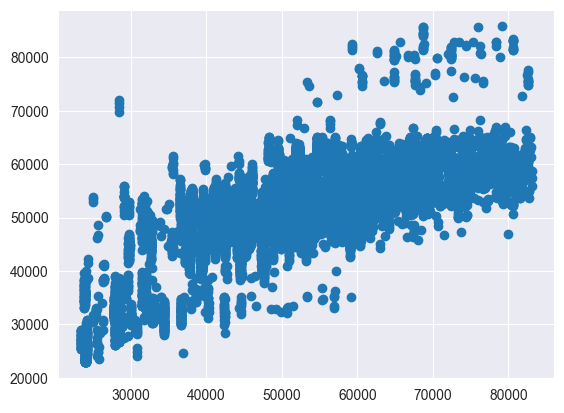

In [56]:
import matplotlib.pyplot as plt

plt.scatter(y_test_list, predicted_prices)
